<a href="https://colab.research.google.com/github/rachelinaputri/Fashion-MNIST/blob/main/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [10]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random

# -----------------------------------
import tensorflow as tf
import keras
from tensorflow import keras
import keras_tuner as kt

In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [13]:
class_names = ['0 Top/T-Shirt', '1 Trouser', '2 Pullover', '3 Drees', '4 Coat', '5 Sandal', '6 Shirt', '7 Sneaker', '8 Bag', '9 Ankle Boot']
class_names

['0 Top/T-Shirt',
 '1 Trouser',
 '2 Pullover',
 '3 Drees',
 '4 Coat',
 '5 Sandal',
 '6 Shirt',
 '7 Sneaker',
 '8 Bag',
 '9 Ankle Boot']

In [14]:
train_images  = train_images / 255.0
test_images = test_images / 255.0

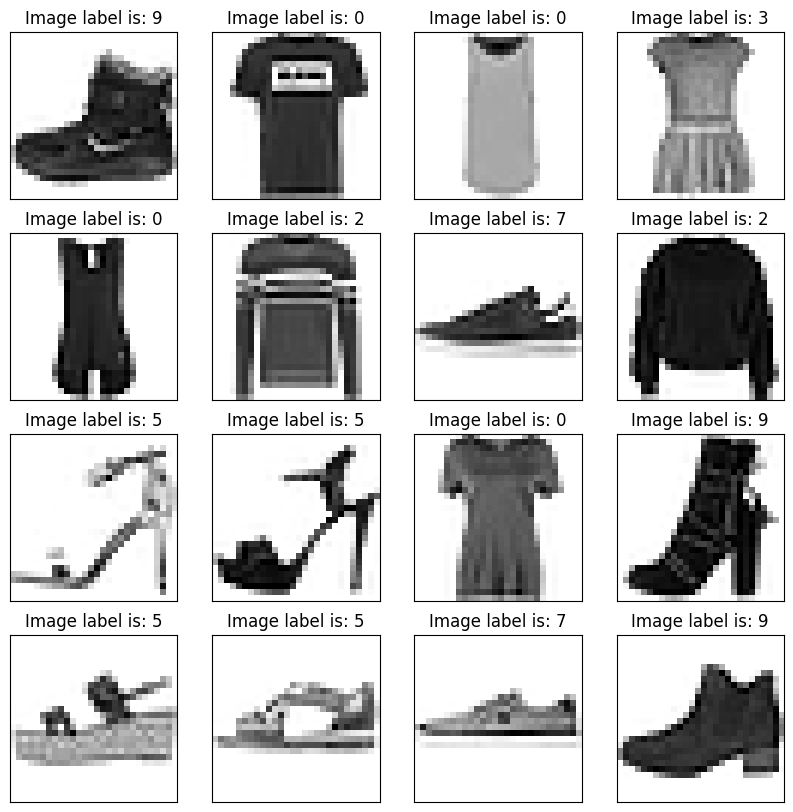

In [15]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.title("Image label is: {}".format(train_labels[i]))
plt.show()

In [16]:
x_train = train_images.reshape(-1,28,28,1)
x_test = test_images.reshape(-1,28,28,1)

In [17]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [18]:
def build_model(hp):
    model = keras.Sequential([

    # First conv_block
    keras.layers.Conv2D(
        filters = hp.Choice('conv_1_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,4]),
        activation='relu',
        input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2)),

    # Second conv_block
    keras.layers.Conv2D(
        filters = hp.Choice('conv_2_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,4]),
        activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    # --------------------------------
    keras.layers.Flatten(),
    keras.layers.Dense(units = hp.Choice('units', values=[16, 32, 64, 128, 256]),
                       activation='relu'),
    keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)),

    # --------------------------------
    keras.layers.Dense(10)
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                                                            values=[1e-1, 1e-2, 1e-3, 1e-4])),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [19]:
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=5,
                     factor=3,
                     hyperband_iterations=3)

In [21]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
conv_1_filter (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
conv_2_filter (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256], 'ordered': True}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [22]:
tuner.search(x_train,train_labels, epochs=3, validation_split=0.2)

Trial 30 Complete [00h 14m 24s]
val_accuracy: 0.8790000081062317

Best val_accuracy So Far: 0.9161666631698608
Total elapsed time: 02h 25m 53s


In [23]:
best_hps = best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""conv_1_filter is {best_hps.get('conv_1_filter')}""")
print(f"""conv_1_kernel is {best_hps.get('conv_1_kernel')}""")
print(f"""conv_2_filter is {best_hps.get('conv_2_filter')}""")
print(f"""conv_2_kernel is {best_hps.get('conv_2_kernel')}""")
print("-------------------------------------------------")
print(f"""units is {best_hps.get('units')}""")
print(f"""learning_rate is {best_hps.get('learning_rate')}""")
print(f"""dropout is {best_hps.get('dropout')}""")

conv_1_filter is 16
conv_1_kernel is 3
conv_2_filter is 128
conv_2_kernel is 4
-------------------------------------------------
units is 128
learning_rate is 0.001
dropout is 0.2


In [25]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, train_labels,
                    epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 75s 49ms/step - loss: 0.4941 - accuracy: 0.8213 - val_loss: 0.3448 - val_accuracy: 0.8733
Epoch 2/50
1500/1500 [==============================] - 60s 40ms/step - loss: 0.3180 - accuracy: 0.8839 - val_loss: 0.2868 - val_accuracy: 0.8939
Epoch 3/50
1500/1500 [==============================] - 58s 39ms/step - loss: 0.2690 - accuracy: 0.9017 - val_loss: 0.2693 - val_accuracy: 0.8985
Epoch 4/50
1500/1500 [==============================] - 59s 39ms/step - loss: 0.2378 - accuracy: 0.9127 - val_loss: 0.2424 - val_accuracy: 0.9116
Epoch 5/50
1500/1500 [==============================] - 57s 38ms/step - loss: 0.2082 - accuracy: 0.9239 - val_loss: 0.2369 - val_accuracy: 0.9125
Epoch 6/50
1500/1500 [==============================] - 65s 44ms/step - loss: 0.1861 - accuracy: 0.9304 - val_loss: 0.2356 - val_accuracy: 0.9172
Epoch 7/50
1500/1500 [==============================] - 59s 40ms/step - loss: 0.1662 - accuracy: 0.9371 - val_loss: 0.2446 -

In [26]:
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(x_train, train_labels,
                         epochs=best_epoch,
                         validation_split=0.2,
                         callbacks=[early_stop])

Epoch 1/40
1500/1500 [==============================] - 70s 45ms/step - loss: 0.4857 - accuracy: 0.8230 - val_loss: 0.3296 - val_accuracy: 0.8808
Epoch 2/40
1500/1500 [==============================] - 72s 48ms/step - loss: 0.3074 - accuracy: 0.8896 - val_loss: 0.2804 - val_accuracy: 0.8946
Epoch 3/40
1500/1500 [==============================] - 57s 38ms/step - loss: 0.2599 - accuracy: 0.9042 - val_loss: 0.2763 - val_accuracy: 0.8931
Epoch 4/40
1500/1500 [==============================] - 59s 39ms/step - loss: 0.2271 - accuracy: 0.9163 - val_loss: 0.2407 - val_accuracy: 0.9110
Epoch 5/40
1500/1500 [==============================] - 61s 40ms/step - loss: 0.2012 - accuracy: 0.9247 - val_loss: 0.2484 - val_accuracy: 0.9099
Epoch 6/40
1500/1500 [==============================] - 56s 37ms/step - loss: 0.1766 - accuracy: 0.9342 - val_loss: 0.2339 - val_accuracy: 0.9172
Epoch 7/40
1500/1500 [==============================] - 60s 40ms/step - loss: 0.1592 - accuracy: 0.9389 - val_loss: 0.2419 -

In [27]:
hypermodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 128)       32896     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3200)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

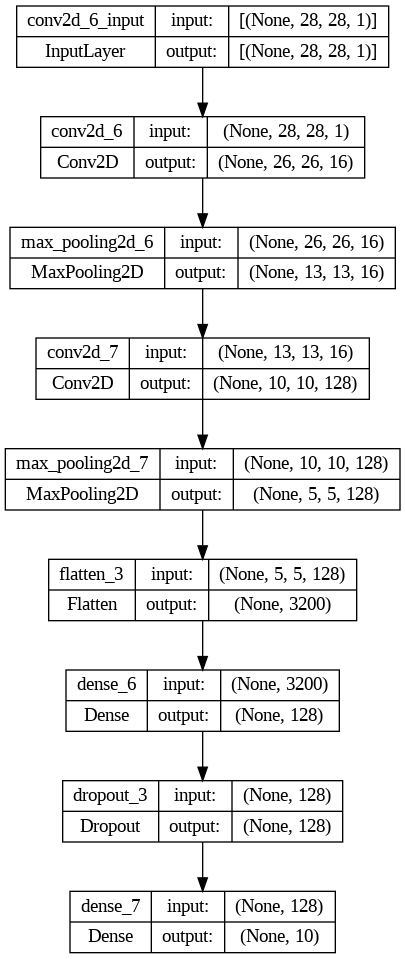

In [28]:
keras.utils.plot_model(hypermodel, show_shapes=True)

1/1 [==============================] - 0s 179ms/step


<ipython-input-29-9b1ff56280e4>:20: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-29-9b1ff56280e4>:23: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


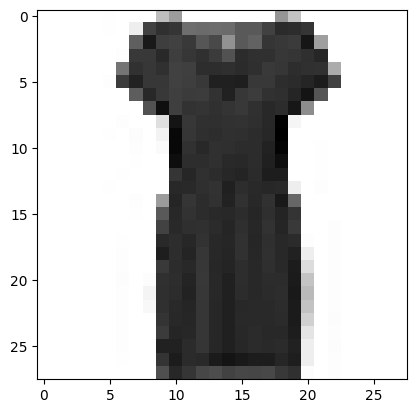

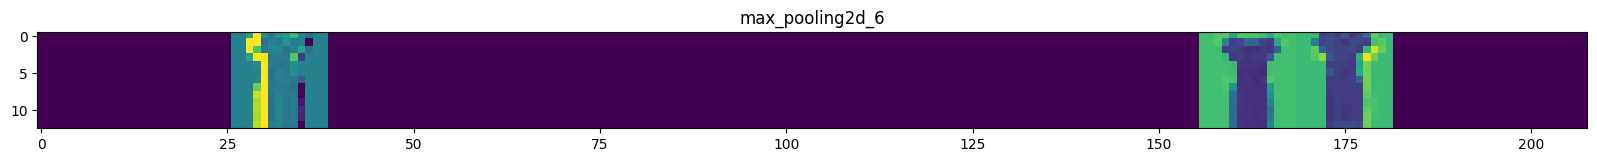

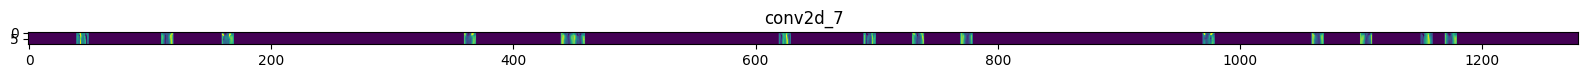

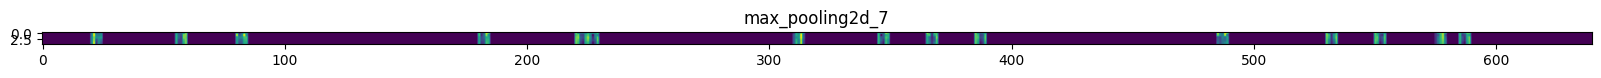

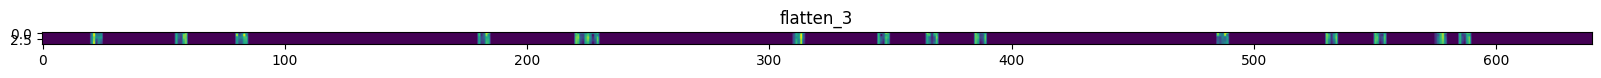

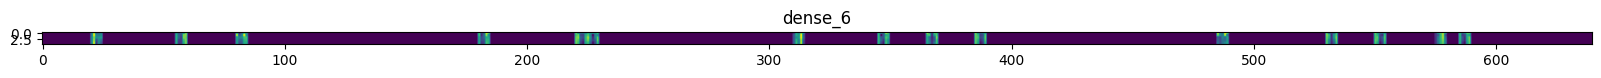

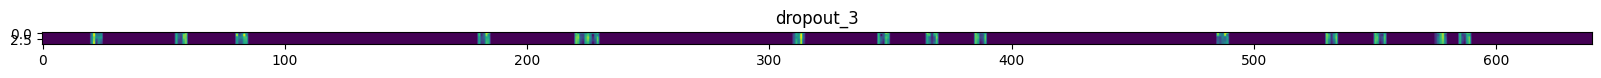

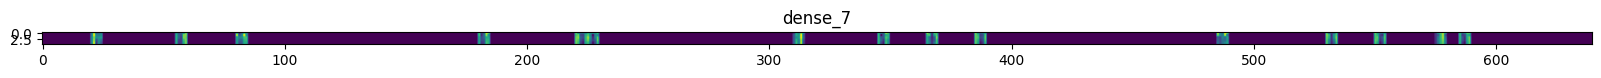

In [29]:
successive_outputs = [layer.output for layer in hypermodel.layers[1:]]
visualization_model = keras.models.Model(inputs = hypermodel.input, outputs = successive_outputs)
index = 20
plt.imshow(train_images[index], cmap=plt.cm.binary)

x = train_images[index]
x = x.reshape((1,) + x.shape)
x /= 255
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in hypermodel.layers[1:]]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [30]:
eval_result = hypermodel.evaluate(x_test, test_labels)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 3s 9ms/step - loss: 0.2614 - accuracy: 0.9155
[test loss, test accuracy]: [0.26142364740371704, 0.9154999852180481]


In [31]:
pred = hypermodel.predict(x_test)

print("Prediction is -> {}".format(pred[12]))
print("Actual value is -> {}".format(test_labels[12]))
print("The highest value for label is {}".format(np.argmax(pred[12])))

313/313 [==============================] - 4s 12ms/step
Prediction is -> [ -7.8371925 -11.408677   -9.742021   -9.14332   -15.117557    7.0288143
 -14.629996    6.223911   -2.6766949  -4.9576592]
Actual value is -> 7
The highest value for label is 5


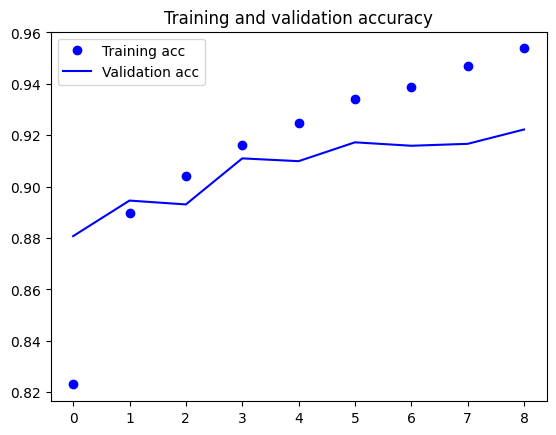

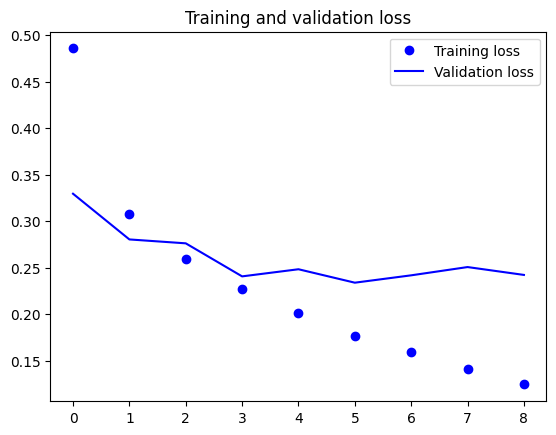

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()